## Analysis of principal actions (panel C)

In [1]:
from definitions import ROOT_DIR
import os
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from functions_notebook import make_parallel_envs,set_config
import pickle
from stable_baselines3.common.vec_env import VecNormalize
from sb3_contrib import RecurrentPPO
from envs.environment_factory import EnvironmentFactory
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

/home/ingster/anaconda3/envs/MyoChallenge2/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


MyoSuite:> Registering Myo Envs


### A. Performance vs. number of dimensions removed in the action space

1. Generate and save the actions. __Go to point 2. to directly load the previously-obtained data.__

In [4]:
num_ep = 20
n_comp = 39

PATH_TO_NORMALIZED_ENV = os.path.join(
    ROOT_DIR,
    "trained_models/curriculum_steps_complete_baoding_winner/32_phase_2_smaller_rate_resume/env.pkl",
)
PATH_TO_PRETRAINED_NET = os.path.join(
    ROOT_DIR,
    "trained_models/curriculum_steps_complete_baoding_winner/32_phase_2_smaller_rate_resume/model.zip",
)

env_name = "CustomMyoBaodingBallsP2"
render = False

config = set_config(period=5,rot_dir="cw")
rollouts = []

envs = make_parallel_envs(env_name, config, num_env=1)
envs = VecNormalize.load(PATH_TO_NORMALIZED_ENV, envs)
envs.training = False
envs.norm_reward = False
custom_objects = {
    "learning_rate": lambda _: 0,
    "lr_schedule": lambda _: 0,
    "clip_range": lambda _: 0,
}
model = RecurrentPPO.load(
        PATH_TO_PRETRAINED_NET, env=envs, device="cpu", custom_objects=custom_objects
    )

eval_model = model
eval_env = EnvironmentFactory.create(env_name,**config)

for n in range(num_ep):
    acts = []
    cum_reward = 0
    lstm_states = None
    obs = eval_env.reset()
    episode_starts = np.ones((1,), dtype=bool)
    done = False
    timestep = 0
    while not done: 
        if render :
            eval_env.sim.render(mode="window")
            
        timestep += 1
        action, lstm_states = eval_model.predict(envs.normalize_obs(obs),
                                                state=lstm_states,
                                                episode_start=episode_starts,
                                                deterministic=True,
                                                )
                                                    
        obs, rewards, done, info = eval_env.step(action)
        episode_starts = done
        cum_reward += rewards
        acts.append(action)
    print('episode %s : '%n,cum_reward)
    rollouts.append({'reward':cum_reward,'action':np.array(acts)})

'''fp = ""
fp_rollouts = open(fp, 'wb')
pickle.dump(rollouts,fp_rollouts)
fp_rollouts.close()'''

MyoSuite:> Registering Myo Envs
episode 0 :  620.0
episode 1 :  845.0
episode 2 :  675.0
episode 3 :  490.0
episode 4 :  805.0
episode 5 :  875.0
episode 6 :  945.0
episode 7 :  975.0
episode 8 :  900.0
episode 9 :  900.0
episode 10 :  930.0
episode 11 :  895.0
episode 12 :  495.0
episode 13 :  610.0
episode 14 :  825.0
episode 15 :  745.0
episode 16 :  620.0
episode 17 :  860.0
episode 18 :  840.0
episode 19 :  890.0


'fp = ""\nfp_rollouts = open(fp, \'wb\')\npickle.dump(rollouts,fp_rollouts)\nfp_rollouts.close()'

2. Load the actions

In [6]:
# Load the file from Basecamp : 'rollouts'
rollouts = pickle.load(open('/home/ingster/Bureau/SIL-BigResults/rollouts','rb'))
n_comp = 39

3. __Go to point 4. to directly load the previously-obtained data.__\
a. Compute the principal actions \
b. Compute the performance when the actions are projected on a progressively lower-dimensional action subspace\
c. Save the data

In [7]:
actions = np.concatenate([rollout['action'] for rollout in rollouts])
performance = []
pca = PCA(n_components=n_comp).fit(actions)

for k in range(n_comp):
    print(k)
    components = pca.components_[:n_comp-k]
    performance_ep = []
    for n in range(num_ep):
        acts = []
        cum_reward = 0
        lstm_states = None
        obs = eval_env.reset()
        episode_starts = np.ones((1,), dtype=bool)
        done = False
        timestep = 0
        while not done: 
            if render :
                eval_env.sim.render(mode="window")
                
            timestep += 1
            action, lstm_states = eval_model.predict(envs.normalize_obs(obs),
                                                    state=lstm_states,
                                                    episode_start=episode_starts,
                                                    deterministic=True,
                                                    )
            
            action_proj = np.dot(action.reshape(-1,39)-pca.mean_,components.T)
            action_backproj = np.dot(action_proj,components)+pca.mean_
            obs, rewards, done, info = eval_env.step(action_backproj.reshape(39,))
            episode_starts = done
            cum_reward += rewards
        performance_ep.append(cum_reward)
    performance.append({'components':components,'reward':np.mean(np.array(performance_ep))})

'''fp = ""
fp_acts_pcs = open(fp, 'wb')
pickle.dump(performance,fp_acts_pcs)
fp_acts_pcs.close()'''

0
1


KeyboardInterrupt: 

4. Load the performances vs. number of principal actions

In [7]:
# Load the file from Basecamp : 'performance_actions_components_t'
performance_components = pickle.load(open('/home/ingster/Bureau/SIL-BigResults/performance_actions_components_t','rb'))
n_comp = 39

5. Plot the performance vs. number of dimensions removed in the action space

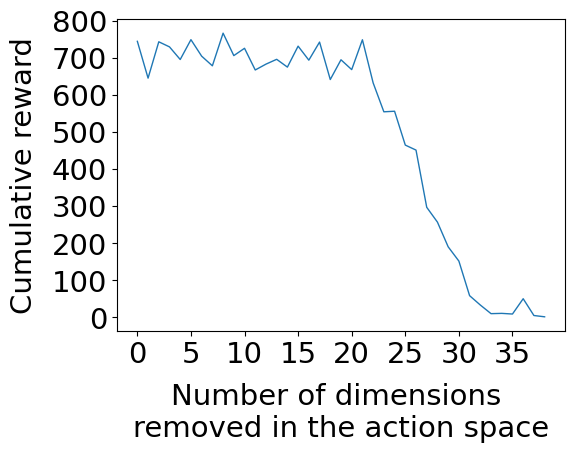

In [8]:
perfs = [d['reward'] for d in performance_components]
comps = [d['components'] for d in performance_components]
plt.plot([k for k in range(n_comp)],perfs,linewidth=1)
plt.xlabel('Number of dimensions \nremoved in the action space',fontsize=21,labelpad=10)
plt.ylabel('Cumulative reward',fontsize=21,labelpad=10)
plt.yticks(fontsize=21)
plt.xticks(fontsize=21)
plt.subplots_adjust(left=0.2,bottom=0.23)
plt.show()

### B. Visualize the first principal actions
1. Load the principal actions

In [9]:
# Load the file from Basecamp : 'performance_actions_components_t'
performance_components = pickle.load(open('/home/ingster/Bureau/SIL-BigResults/performance_actions_components_t','rb'))
principal_actions = [d['components'] for d in performance_components][0]

2. Render

In [11]:
PATH_TO_NORMALIZED_ENV = os.path.join(
    ROOT_DIR,
    "trained_models/curriculum_steps_complete_baoding_winner/32_phase_2_smaller_rate_resume/env.pkl",
)
PATH_TO_PRETRAINED_NET = os.path.join(
    ROOT_DIR,
    "trained_models/curriculum_steps_complete_baoding_winner/32_phase_2_smaller_rate_resume/model.zip",
)

env_name = "CustomMyoBaodingBallsP2"
render = False

config = set_config(period=5,rot_dir="cw")
rollouts = []

envs = make_parallel_envs(env_name, config, num_env=1)
envs = VecNormalize.load(PATH_TO_NORMALIZED_ENV, envs)
envs.training = False
envs.norm_reward = False
custom_objects = {
    "learning_rate": lambda _: 0,
    "lr_schedule": lambda _: 0,
    "clip_range": lambda _: 0,
}
model = RecurrentPPO.load(
        PATH_TO_PRETRAINED_NET, env=envs, device="cpu", custom_objects=custom_objects
    )

eval_model = model
eval_env = EnvironmentFactory.create(env_name,**config)
render = True
for n in range(10): # The principal action will be executed 10 times
    cum_reward = 0
    lstm_states = None
    obs = eval_env.reset()
    episode_starts = np.ones((1,), dtype=bool)
    done = False
    timestep = 0
    while timestep < 500 : 
        if render :
            eval_env.sim.render(mode="window")
            
        timestep += 1
        action, lstm_states = eval_model.predict(envs.normalize_obs(obs),
                                                state=lstm_states,
                                                episode_start=episode_starts,
                                                deterministic=True,
                                                )
        obs, rewards, done, info = eval_env.step(principal_actions[1]) # Here we choose to visualize the 2nd principal action
        episode_starts = done
        cum_reward += rewards

MyoSuite:> Registering Myo Envs


/home/ingster/anaconda3/envs/MyoChallenge2/lib/python3.8/site-packages/stable_baselines3/common/save_util.py:166: UserWarning: Could not deserialize object _last_lstm_states. Consider using `custom_objects` argument to replace this object.
  warnings.warn(


Creating window glfw


: 

: 

### C. Heatmap of principal actions

1. Load the principal actions (same data as that generated in point A.3.and loaded in point A.4.) 

In [2]:
# Load the file from Basecamp : 'performance_actions_components_t'
performance_components = pickle.load(open('/home/ingster/Bureau/SIL-BigResults/performance_actions_components_t','rb'))
principal_actions = [d['components'] for d in performance_components][0]

2. Plot the heatmap

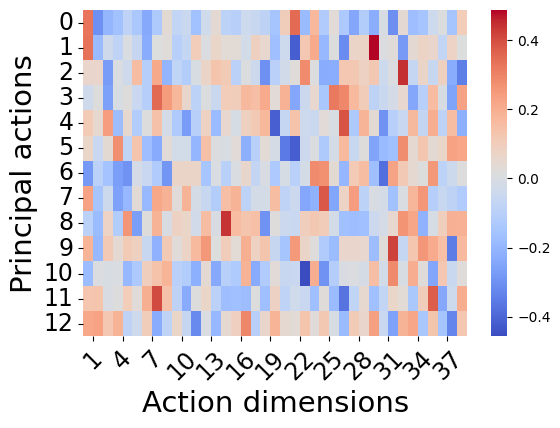

In [3]:
fig = sns.heatmap(pd.DataFrame(principal_actions[:13]),cmap="coolwarm").get_figure()
plt.xlabel('Action dimensions',fontsize=21)
plt.ylabel('Principal actions',fontsize=21)
plt.yticks(rotation=0,fontsize=17)
plt.xticks(ticks=np.arange(1,40,3),labels=np.arange(1,40,3),rotation=45,fontsize=17)
plt.subplots_adjust(left=0.15,bottom=0.2)
plt.show()

### D. Principal action vs. phase of rotation (time step)

1. Generate and save the actions. __Go to point 2. to directly load the previously-obtained data.__

In [5]:
num_ep = 100
n_comp = 39

PATH_TO_NORMALIZED_ENV = os.path.join(
    ROOT_DIR,
    "trained_models/curriculum_steps_complete_baoding_winner/32_phase_2_smaller_rate_resume/env.pkl",
)
PATH_TO_PRETRAINED_NET = os.path.join(
    ROOT_DIR,
    "trained_models/curriculum_steps_complete_baoding_winner/32_phase_2_smaller_rate_resume/model.zip",
)

env_name = "CustomMyoBaodingBallsP2"
render = False

config = set_config(period=5,rot_dir="cw")
rollouts = []

envs = make_parallel_envs(env_name, config, num_env=1)
envs = VecNormalize.load(PATH_TO_NORMALIZED_ENV, envs)
envs.training = False
envs.norm_reward = False
custom_objects = {
    "learning_rate": lambda _: 0,
    "lr_schedule": lambda _: 0,
    "clip_range": lambda _: 0,
}
model = RecurrentPPO.load(
        PATH_TO_PRETRAINED_NET, env=envs, device="cpu", custom_objects=custom_objects
    )

eval_model = model
eval_env = EnvironmentFactory.create(env_name,**config)
actions = []
for n in range(num_ep):
    print(n)
    acts_1ep = []
    cum_reward = 0
    lstm_states = None
    obs = eval_env.reset()
    episode_starts = np.ones((1,), dtype=bool)
    done = False
    timestep = 0
    while not done: 
        if render :
            eval_env.sim.render(mode="window")
            
        timestep += 1
        action, lstm_states = eval_model.predict(envs.normalize_obs(obs),
                                                state=lstm_states,
                                                episode_start=episode_starts,
                                                deterministic=True,
                                                )
                                                    
        obs, rewards, done, info = eval_env.step(action)
        episode_starts = done
        cum_reward += rewards   
        acts_1ep.append(action)
    if len(acts_1ep) < 200 :
        temp = np.zeros((200,39))
        temp[:len(acts_1ep)] += acts_1ep
        acts_1ep = temp
    actions.append(np.array(acts_1ep))

'''fp = ""
fp_rollouts = open(fp, 'wb')
pickle.dump(actions,fp_rollouts)
fp_rollouts.close()'''

MyoSuite:> Registering Myo Envs


/home/ingster/anaconda3/envs/MyoChallenge2/lib/python3.8/site-packages/stable_baselines3/common/save_util.py:166: UserWarning: Could not deserialize object _last_lstm_states. Consider using `custom_objects` argument to replace this object.
  warnings.warn(


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


'fp = ""\nfp_rollouts = open(fp, \'wb\')\npickle.dump(actions,fp_rollouts)\nfp_rollouts.close()'

2. Load the actions

In [6]:
# Load the file from Basecamp : 'rollout_100ep'
actions = pickle.load(open('/home/ingster/Bureau/SIL-BigResults/rollout_100ep','rb'))
n_comp = 39

3. a. Compute the average principal actions \
b. Plot the PAs weights vs. time for the rotation phase

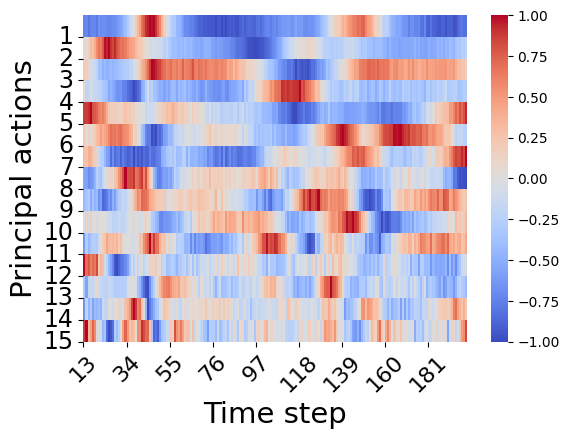

In [7]:
pca = PCA(n_components=n_comp)
mean_actions = sum(actions)/len(actions)
mean_weights = pca.fit_transform(mean_actions)

minmax = MinMaxScaler(feature_range=(-1,1))
weights=[]
t_min = 13; t_max = 200 # Rotation phase (transient phase from 0 to 13 time steps)
for j in range(15):
    norm_weights = minmax.fit_transform(mean_weights[t_min:,j].reshape(t_max-t_min,1))
    weights.append(norm_weights)

fig = sns.heatmap(pd.DataFrame(np.squeeze(weights)),cmap="coolwarm").get_figure()
plt.yticks(ticks=np.arange(1,16,1),labels=np.arange(1,16,1),rotation=0,fontsize=17)
plt.xticks(rotation=45,ticks=np.arange(0,t_max-t_min,21),labels=np.arange(t_min,t_max,21),fontsize=16)
plt.xlabel('Time step',fontsize=21)
plt.ylabel('Principal actions',fontsize=21)
plt.subplots_adjust(left=0.15,bottom=0.2)
plt.show()